第1章：数据加载与预处理

1.3 数据加载
正在加载主数据...
✗ 数据文件未找到: [Errno 2] No such file or directory: 'data/raw/main_data_advanced.csv'
正在创建模拟数据...
✓ 模拟数据创建完成

主数据预览:
   城市    年份  跨境数据传输总量_TB        GDP_亿元  数字经济核心产业增加值_亿元  研发经费投入_亿元  5G基站数量  \
0  香港  2019   517.162468  25579.984855      10000.0000  750.00000    2781   
1  香港  2020   501.558375  25588.385479      10600.0000  795.00000    6959   
2  香港  2021   358.454102  27196.246333      11236.0000  842.70000    4393   
3  香港  2022   302.706989  29849.113265      11910.1600  893.26200    1498   
4  香港  2023   306.942389  30905.892519      12624.7696  946.85772    4403   

    数据交易额_亿元  
0   6.606935  
1  45.865061  
2  12.745237  
3  13.633353  
4  12.550140  

数据类型:
float64    5
int64      2
object     1
dtype: int64

OD矩阵预览:
              香港          澳门          广州          深圳          珠海          佛山  \
起点城市                                                                           
香港    591.111465  366.911972   81.133474  201.230118  191.944735  152.00

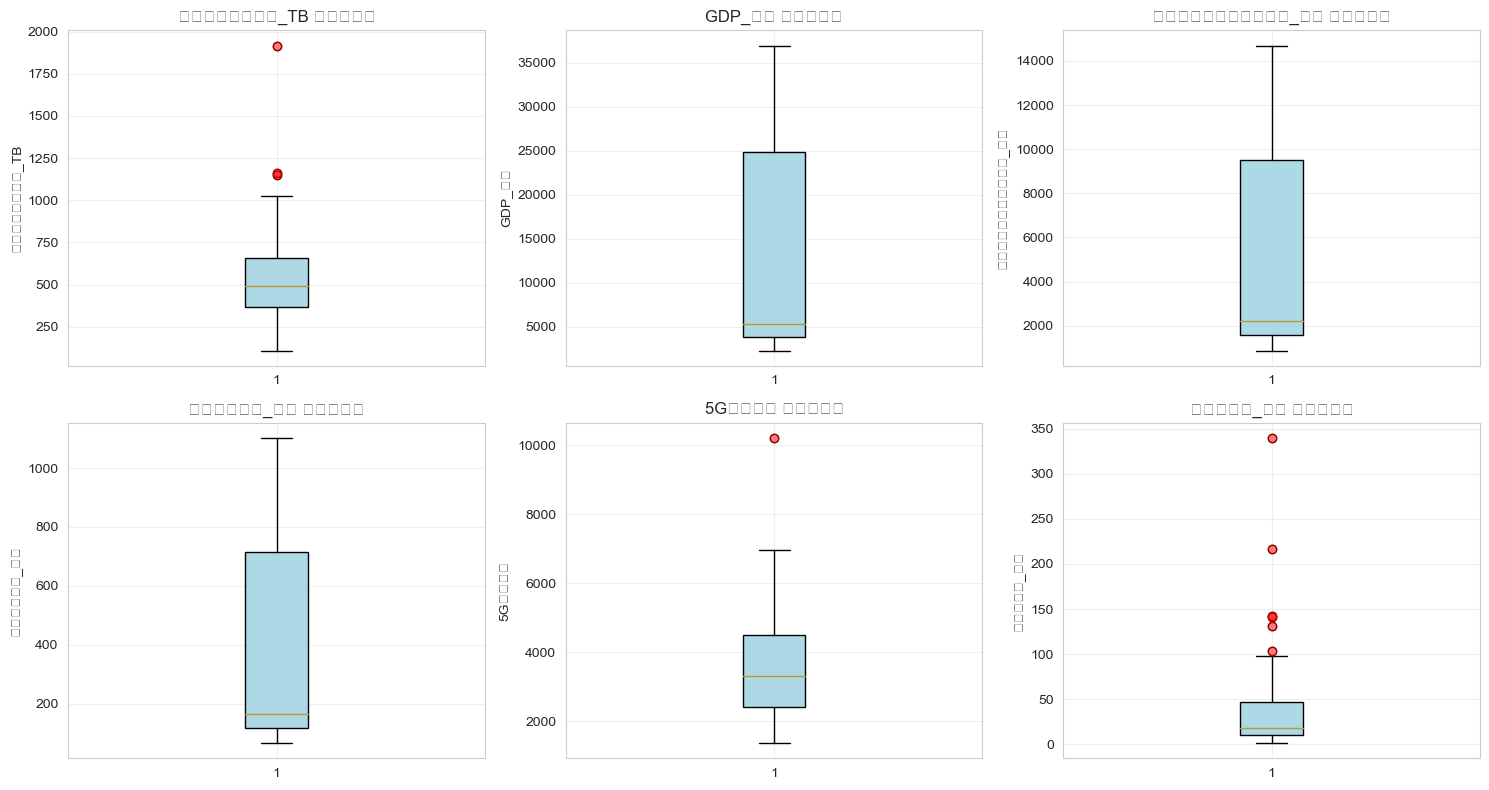


----------------------------------------
1.7 异常值处理（缩尾处理）
----------------------------------------
  列 '跨境数据传输总量_TB': 1个低异常值, 1个高异常值
  列 'GDP_亿元': 1个低异常值, 1个高异常值
  列 '数字经济核心产业增加值_亿元': 1个低异常值, 1个高异常值
  列 '研发经费投入_亿元': 1个低异常值, 1个高异常值
  列 '5G基站数量': 1个低异常值, 1个高异常值
  列 '数据交易额_亿元': 1个低异常值, 1个高异常值
✓ 异常值处理完成

----------------------------------------
1.8 数据变换和标准化
----------------------------------------
数据变换报告:
            变量      原始偏度     变换后偏度     变换
0  跨境数据传输总量_TB  1.183612 -0.290535  log1p
1     数据交易额_亿元  2.524284  0.425207  log1p

----------------------------------------
1.9 正态性检验
----------------------------------------
正态性检验结果:
               变量  样本量        偏度        峰度  Shapiro统计量    Shapiro p值  \
0              年份   55  0.000000 -1.300000    0.888240  9.946723e-05   
1     跨境数据传输总量_TB   55 -0.290535  0.251593    0.987199  8.229538e-01   
2          GDP_亿元   55  0.850892 -0.931907    0.782224  1.295180e-07   
3  数字经济核心产业增加值_亿元   55  0.883399 -0.842407    0.786209  1.598548e-07   
4      

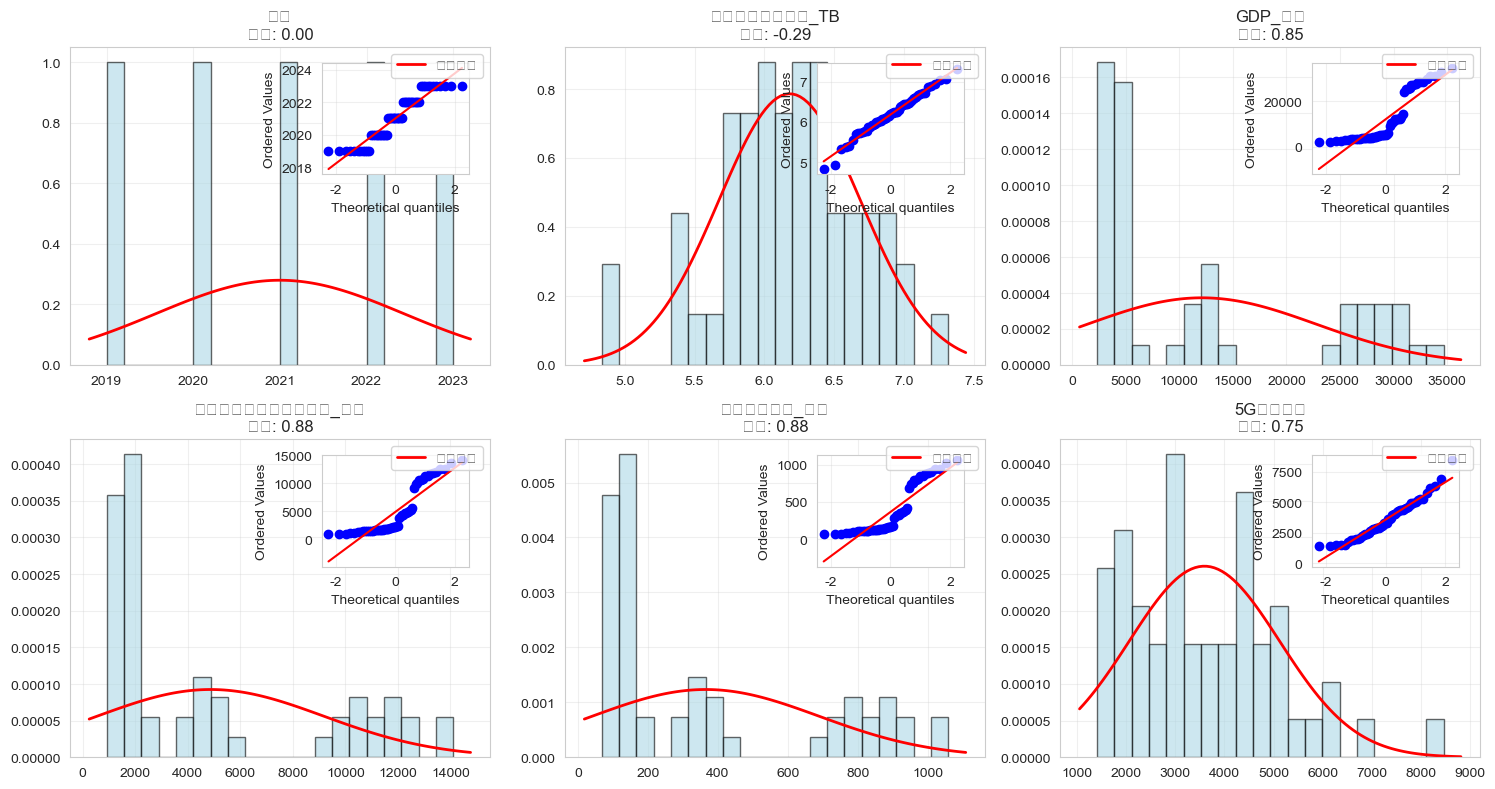


----------------------------------------
1.10 数据标准化
----------------------------------------
标准化后数据统计:
           年份  跨境数据传输总量_TB  GDP_亿元  数字经济核心产业增加值_亿元  研发经费投入_亿元  5G基站数量  \
count  55.000       55.000  55.000          55.000     55.000  55.000   
mean    0.000        0.000   0.000           0.000      0.000  -0.000   
std     1.000        1.000   1.000           1.000      1.000   1.000   
min    -1.401       -2.654  -0.917          -0.918     -0.918  -1.428   
25%    -0.701       -0.536  -0.771          -0.762     -0.762  -0.776   
50%     0.000        0.030  -0.636          -0.617     -0.617  -0.192   
75%     0.701        0.612   1.191           1.080      1.080   0.600   
max     1.401        2.242   2.111           2.143      2.143   3.175   

       数据交易额_亿元  
count    55.000  
mean     -0.000  
std       1.000  
min      -1.896  
25%      -0.743  
50%      -0.223  
75%       0.665  
max       2.375  

----------------------------------------
1.11 多重共线性诊断
---------------------

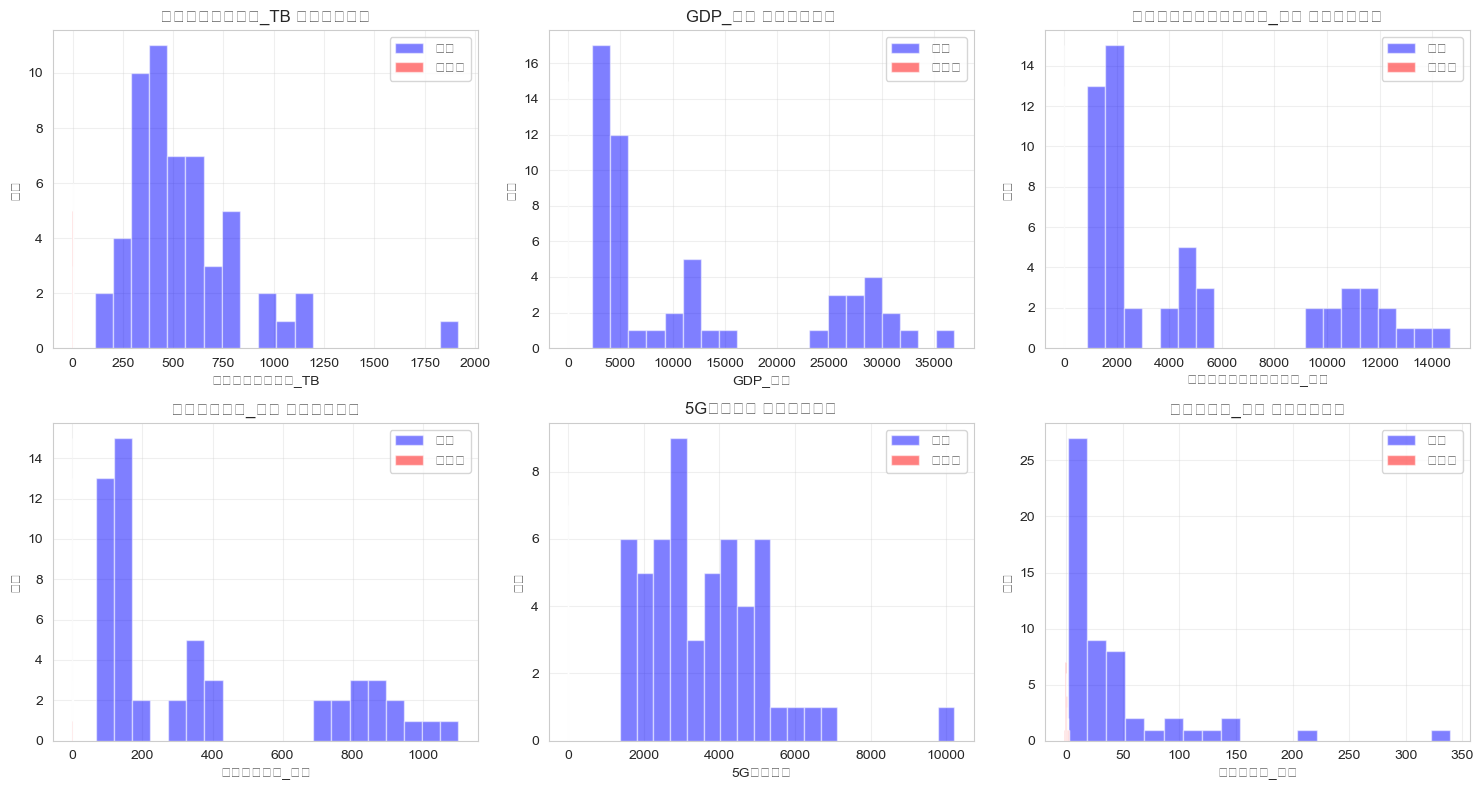

In [5]:
# notebooks/01_data_preprocessing.ipynb

"""
# 第1章：数据加载与预处理
## 粤港澳大湾区数据要素流动多元统计分析实验

**目标**: 
1. 加载和检查原始数据
2. 处理缺失值和异常值
3. 数据变换和标准化
4. 生成数据质量报告

**输入文件**:
- data/raw/main_data_advanced.csv (主数据)
- data/raw/od_matrix_2023.csv (OD矩阵)

**输出文件**:
- data/processed/cleaned_data.csv
- outputs/reports/data_quality_report.json
"""

# 1.1 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import json
import os
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

warnings.filterwarnings('ignore')

# 设置中文字体和绘图样式
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

print("=" * 60)
print("第1章：数据加载与预处理")
print("=" * 60)

# 自定义 JSON 编码器来处理 numpy 类型
class NumpyEncoder(json.JSONEncoder):
    """自定义 JSON 编码器，处理 numpy 数据类型"""
    def default(self, obj):
        if isinstance(obj, (np.integer, np.int32, np.int64)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, pd.Timestamp):
            return obj.strftime('%Y-%m-%d %H:%M:%S')
        elif isinstance(obj, pd.Series):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

# 1.2 数据加载函数
def load_data():
    """加载主数据和OD矩阵"""
    try:
        # 加载主数据
        print("正在加载主数据...")
        main_data = pd.read_csv('data/raw/main_data_advanced.csv', encoding='utf-8')
        print(f"✓ 主数据加载成功，形状: {main_data.shape}")
        print(f"  时间范围: {main_data['年份'].min()} - {main_data['年份'].max()}")
        print(f"  城市数量: {main_data['城市'].nunique()}")
        
        # 加载OD矩阵
        print("\n正在加载OD矩阵...")
        od_matrix = pd.read_csv('data/raw/od_matrix_2023.csv', encoding='utf-8')
        od_matrix.set_index('起点城市', inplace=True)
        print(f"✓ OD矩阵加载成功，形状: {od_matrix.shape}")
        
        return main_data, od_matrix
        
    except FileNotFoundError as e:
        print(f"✗ 数据文件未找到: {e}")
        print("正在创建模拟数据...")
        return create_simulated_data()

def create_simulated_data():
    """创建模拟数据"""
    # 大湾区11个城市
    cities = ['香港', '澳门', '广州', '深圳', '珠海', '佛山', '惠州', '东莞', '中山', '江门', '肇庆']
    years = [2019, 2020, 2021, 2022, 2023]
    
    np.random.seed(42)
    data = []
    
    # 基础参数
    base_params = {
        '香港': {'gdp_base': 25000, 'growth': 0.06},
        '澳门': {'gdp_base': 5000, 'growth': 0.05},
        '广州': {'gdp_base': 23000, 'growth': 0.07},
        '深圳': {'gdp_base': 27000, 'growth': 0.08},
        '珠海': {'gdp_base': 3500, 'growth': 0.07},
        '佛山': {'gdp_base': 11000, 'growth': 0.06},
        '惠州': {'gdp_base': 4200, 'growth': 0.065},
        '东莞': {'gdp_base': 9500, 'growth': 0.075},
        '中山': {'gdp_base': 3500, 'growth': 0.06},
        '江门': {'gdp_base': 3200, 'growth': 0.055},
        '肇庆': {'gdp_base': 2200, 'growth': 0.06}
    }
    
    for city in cities:
        base = base_params[city]
        for i, year in enumerate(years):
            growth_factor = (1 + base['growth']) ** i
            
            record = {
                '城市': city,
                '年份': year,
                '跨境数据传输总量_TB': np.random.lognormal(6, 0.5) * growth_factor,
                'GDP_亿元': base['gdp_base'] * growth_factor * np.random.uniform(0.95, 1.05),
                '数字经济核心产业增加值_亿元': base['gdp_base'] * 0.4 * growth_factor,
                '研发经费投入_亿元': base['gdp_base'] * 0.03 * growth_factor,
                '5G基站数量': int(np.random.lognormal(8, 0.5) * growth_factor),
                '数据交易额_亿元': np.random.lognormal(3, 1) * growth_factor,
            }
            data.append(record)
    
    main_data = pd.DataFrame(data)
    
    # 创建OD矩阵
    od_matrix = pd.DataFrame(
        np.random.lognormal(5, 1, (11, 11)),
        index=cities,
        columns=cities
    )
    od_matrix.index.name = '起点城市'
    
    print("✓ 模拟数据创建完成")
    return main_data, od_matrix

# 1.3 加载数据
print("\n1.3 数据加载")
main_data, od_matrix = load_data()

# 显示数据预览
print("\n主数据预览:")
print(main_data.head())
print(f"\n数据类型:\n{main_data.dtypes.value_counts()}")

print("\nOD矩阵预览:")
print(od_matrix.head())

# 1.4 数据质量检查
print("\n" + "-" * 40)
print("1.4 数据质量检查")
print("-" * 40)

# 检查缺失值
def check_missing_data(df):
    """检查缺失值"""
    missing_count = df.isnull().sum()
    missing_percent = (missing_count / len(df)) * 100
    
    missing_df = pd.DataFrame({
        '缺失数量': missing_count,
        '缺失比例%': missing_percent
    }).sort_values('缺失比例%', ascending=False)
    
    return missing_df

missing_report = check_missing_data(main_data)
print("缺失值统计:")
print(missing_report[missing_report['缺失数量'] > 0].head(10))

# 可视化缺失值
if missing_report['缺失数量'].sum() > 0:
    plt.figure(figsize=(12, 6))
    missing_plot_data = missing_report[missing_report['缺失数量'] > 0]['缺失比例%'].head(20)
    missing_plot_data.plot(kind='bar')
    plt.title('缺失值比例分布（前20个变量）')
    plt.xlabel('变量')
    plt.ylabel('缺失比例 (%)')
    plt.axhline(y=5, color='r', linestyle='--', alpha=0.5, label='5%阈值')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 1.5 缺失值处理
print("\n" + "-" * 40)
print("1.5 缺失值处理")
print("-" * 40)

def impute_missing_values(df, method='median'):
    """缺失值插补"""
    print(f"使用{method}方法进行缺失值插补...")
    
    df_imputed = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    if method == 'median':
        # 中位数插补
        for col in numeric_cols:
            if df[col].isnull().sum() > 0:
                median_val = df[col].median()
                df_imputed[col] = df[col].fillna(median_val)
                print(f"  列 '{col}': {int(df[col].isnull().sum())}个缺失值 → 中位数{float(median_val):.2f}")
    
    elif method == 'mean':
        # 均值插补
        for col in numeric_cols:
            if df[col].isnull().sum() > 0:
                mean_val = df[col].mean()
                df_imputed[col] = df[col].fillna(mean_val)
    
    elif method == 'forward':
        # 前向填充（适用于时间序列）
        df_imputed = df_imputed.sort_values(['城市', '年份'])
        df_imputed[numeric_cols] = df_imputed.groupby('城市')[numeric_cols].ffill()
    
    print("✓ 缺失值插补完成")
    return df_imputed

# 使用中位数插补
main_data_imputed = impute_missing_values(main_data, method='median')

# 1.6 异常值检测
print("\n" + "-" * 40)
print("1.6 异常值检测")
print("-" * 40)

def detect_outliers_iqr(df, columns=None, threshold=1.5):
    """使用IQR方法检测异常值"""
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns
    
    outlier_report = {}
    
    for col in columns:
        Q1 = float(df[col].quantile(0.25))
        Q3 = float(df[col].quantile(0.75))
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        
        if len(outliers) > 0:
            outlier_report[col] = {
                '异常值数量': int(len(outliers)),
                '异常值比例%': float((len(outliers) / len(df)) * 100),
                '下限': float(lower_bound),
                '上限': float(upper_bound),
                '最小值': float(df[col].min()),
                '最大值': float(df[col].max())
            }
    
    return pd.DataFrame(outlier_report).T

# 检测关键指标的异常值
key_columns = ['跨境数据传输总量_TB', 'GDP_亿元', '数字经济核心产业增加值_亿元', 
               '研发经费投入_亿元', '5G基站数量', '数据交易额_亿元']

outlier_report = detect_outliers_iqr(main_data_imputed, columns=key_columns)
print("异常值检测报告:")
print(outlier_report)

# 可视化异常值
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, col in enumerate(key_columns):
    ax = axes[idx]
    data = main_data_imputed[col].dropna()
    
    # 创建箱线图
    bp = ax.boxplot(data, vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    
    # 添加离群点
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)]
    
    if len(outliers) > 0:
        ax.plot([1]*len(outliers), outliers, 'ro', alpha=0.5)
    
    ax.set_title(f'{col} 异常值检测')
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 1.7 异常值处理（缩尾处理）
print("\n" + "-" * 40)
print("1.7 异常值处理（缩尾处理）")
print("-" * 40)

def winsorize_data(df, limits=(0.01, 0.99)):
    """缩尾处理异常值"""
    df_winsorized = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        lower = float(df[col].quantile(limits[0]))
        upper = float(df[col].quantile(limits[1]))
        
        # 记录处理情况
        n_lower = int((df[col] < lower).sum())
        n_upper = int((df[col] > upper).sum())
        
        if n_lower > 0 or n_upper > 0:
            print(f"  列 '{col}': {n_lower}个低异常值, {n_upper}个高异常值")
        
        df_winsorized[col] = df[col].clip(lower, upper)
    
    print("✓ 异常值处理完成")
    return df_winsorized

main_data_clean = winsorize_data(main_data_imputed)

# 1.8 数据变换
print("\n" + "-" * 40)
print("1.8 数据变换和标准化")
print("-" * 40)

def transform_skewed_data(df):
    """对偏斜数据进行变换"""
    df_transformed = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    transformation_report = []
    
    for col in numeric_cols:
        data = df[col].dropna()
        
        if len(data) > 10:
            skewness = float(stats.skew(data))
            
            # 如果数据严重偏斜(|偏度|>1)，进行对数变换
            if abs(skewness) > 1 and (data > 0).all():
                df_transformed[col] = np.log1p(df[col])
                new_skewness = float(stats.skew(df_transformed[col].dropna()))
                transformation_report.append({
                    '变量': col,
                    '原始偏度': skewness,
                    '变换后偏度': new_skewness,
                    '变换': 'log1p'
                })
    
    return df_transformed, pd.DataFrame(transformation_report)

# 应用数据变换
main_data_transformed, transform_report = transform_skewed_data(main_data_clean)

print("数据变换报告:")
if len(transform_report) > 0:
    print(transform_report)
else:
    print("没有变量需要变换")

# 1.9 正态性检验
print("\n" + "-" * 40)
print("1.9 正态性检验")
print("-" * 40)

def test_normality(df, columns=None):
    """正态性检验"""
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns[:10]  # 只检查前10个
    
    normality_results = []
    
    for col in columns:
        data = df[col].dropna()
        
        if len(data) >= 8:  # Shapiro检验要求至少8个样本
            # Shapiro-Wilk检验
            shapiro_stat, shapiro_p = stats.shapiro(data)
            
            # 偏度和峰度
            skewness = float(stats.skew(data))
            kurtosis = float(stats.kurtosis(data))
            
            normality_results.append({
                '变量': col,
                '样本量': int(len(data)),
                '偏度': skewness,
                '峰度': kurtosis,
                'Shapiro统计量': float(shapiro_stat),
                'Shapiro p值': float(shapiro_p),
                '是否正态(p<0.05)': shapiro_p > 0.05
            })
    
    return pd.DataFrame(normality_results)

# 进行正态性检验
normality_results = test_normality(main_data_transformed)
print("正态性检验结果:")
print(normality_results)

# 可视化正态性检验结果
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

variables_to_plot = normality_results['变量'].head(6).tolist()

for idx, var in enumerate(variables_to_plot):
    if idx < len(axes):
        ax = axes[idx]
        data = main_data_transformed[var].dropna()
        
        # 绘制直方图和密度曲线
        ax.hist(data, bins=20, density=True, alpha=0.6, color='lightblue', edgecolor='black')
        
        # 添加正态分布曲线
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, data.mean(), data.std())
        ax.plot(x, p, 'r-', linewidth=2, label='正态分布')
        
        # 添加QQ图
        ax_inset = ax.inset_axes([0.6, 0.6, 0.35, 0.35])
        stats.probplot(data, dist="norm", plot=ax_inset)
        ax_inset.set_title('')
        ax_inset.grid(True, alpha=0.3)
        
        if idx < len(normality_results):
            ax.set_title(f'{var}\n偏度: {normality_results.loc[idx, "偏度"]:.2f}')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 1.10 数据标准化
print("\n" + "-" * 40)
print("1.10 数据标准化")
print("-" * 40)

def standardize_data(df, columns=None):
    """标准化数据"""
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns
    
    df_standardized = df.copy()
    
    for col in columns:
        mean_val = df[col].mean()
        std_val = df[col].std()
        
        if std_val > 0:  # 避免除以0
            df_standardized[col] = (df[col] - mean_val) / std_val
    
    print("✓ 数据标准化完成")
    return df_standardized

# 标准化数值变量
numeric_cols = main_data_transformed.select_dtypes(include=[np.number]).columns
main_data_standardized = main_data_transformed.copy()
main_data_standardized[numeric_cols] = (main_data_transformed[numeric_cols] - 
                                       main_data_transformed[numeric_cols].mean()) / \
                                       main_data_transformed[numeric_cols].std()

print("标准化后数据统计:")
print(main_data_standardized[numeric_cols].describe().round(3))

# 1.11 多重共线性诊断
print("\n" + "-" * 40)
print("1.11 多重共线性诊断")
print("-" * 40)

def check_multicollinearity(df, features):
    """检查多重共线性"""
    # 准备数据
    X = df[features].copy()
    X = X.fillna(X.mean())
    
    # 添加常数项
    X_const = add_constant(X)
    
    # 计算VIF
    vif_data = pd.DataFrame()
    vif_data['变量'] = X_const.columns
    vif_data['VIF'] = [float(variance_inflation_factor(X_const.values, i)) 
                      for i in range(X_const.shape[1])]
    
    # 移除常数项
    vif_data = vif_data[vif_data['变量'] != 'const']
    vif_data = vif_data.sort_values('VIF', ascending=False)
    
    return vif_data

# 选择关键变量进行VIF检验
key_features = ['跨境数据传输总量_TB', 'GDP_亿元', '数字经济核心产业增加值_亿元',
                '研发经费投入_亿元', '5G基站数量', '数据交易额_亿元']

vif_results = check_multicollinearity(main_data_standardized, key_features)
print("VIF检验结果:")
print(vif_results)

# 标记高VIF变量
high_vif = vif_results[vif_results['VIF'] > 10]
if len(high_vif) > 0:
    print(f"\n⚠️  发现 {int(len(high_vif))} 个高VIF变量(VIF>10):")
    print(high_vif)
else:
    print("\n✓ 所有变量VIF均小于10，多重共线性问题不大")

# 1.12 生成数据质量报告
print("\n" + "-" * 40)
print("1.12 生成数据质量报告")
print("-" * 40)

def generate_data_quality_report(df, od_matrix):
    """生成数据质量报告"""
    report = {}
    
    # 基本信息
    report['基本信息'] = {
        '观测数': int(len(df)),
        '变量数': int(len(df.columns)),
        '时间跨度': f"{int(df['年份'].min())} - {int(df['年份'].max())}",
        '城市数量': int(df['城市'].nunique())
    }
    
    # 缺失值统计
    missing_count = df.isnull().sum().sum()
    report['缺失值'] = {
        '总缺失值': int(missing_count),
        '缺失比例%': float((missing_count / df.size) * 100),
        '有缺失的变量数': int((df.isnull().sum() > 0).sum())
    }
    
    # 异常值统计（使用IQR方法）
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    outlier_counts = []
    
    for col in numeric_cols[:10]:  # 只检查前10个数值变量
        Q1 = float(df[col].quantile(0.25))
        Q3 = float(df[col].quantile(0.75))
        IQR = Q3 - Q1
        outliers = int(((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum())
        outlier_counts.append(outliers)
    
    report['异常值'] = {
        '平均异常值比例%': float((sum(outlier_counts) / (len(numeric_cols[:10]) * len(df))) * 100)
    }
    
    # 数据分布
    skewness = df[numeric_cols].skew().abs()
    kurtosis = df[numeric_cols].kurtosis().abs()
    
    report['数据分布'] = {
        '高度偏斜变量(|偏度|>1)': int((skewness > 1).sum()),
        '尖峰/平峰变量(|峰度|>3)': int((kurtosis > 3).sum())
    }
    
    # OD矩阵质量
    if od_matrix is not None:
        report['OD矩阵'] = {
            '形状': f"({od_matrix.shape[0]}, {od_matrix.shape[1]})",
            '总连接数': int((od_matrix > 0).sum().sum()),
            '网络密度': float((od_matrix > 0).sum().sum() / (od_matrix.shape[0] * od_matrix.shape[1]))
        }
    
    # 计算质量评分（0-100分）
    quality_score = 100.0
    
    # 根据缺失值扣分
    missing_percent = report['缺失值']['缺失比例%']
    if missing_percent > 20:
        quality_score -= 30.0
    elif missing_percent > 10:
        quality_score -= 20.0
    elif missing_percent > 5:
        quality_score -= 10.0
    elif missing_percent > 1:
        quality_score -= 5.0
    
    # 根据异常值扣分
    outlier_percent = report['异常值']['平均异常值比例%']
    if outlier_percent > 5:
        quality_score -= 15.0
    elif outlier_percent > 2:
        quality_score -= 10.0
    elif outlier_percent > 1:
        quality_score -= 5.0
    
    report['质量评分'] = float(max(0.0, quality_score))
    
    # 质量评级
    if quality_score >= 90:
        rating = '优秀'
    elif quality_score >= 80:
        rating = '良好'
    elif quality_score >= 70:
        rating = '中等'
    elif quality_score >= 60:
        rating = '合格'
    else:
        rating = '需要改进'
    
    report['质量评级'] = rating
    
    return report

# 生成数据质量报告
quality_report = generate_data_quality_report(main_data_standardized, od_matrix)

print("数据质量评估报告:")
print("=" * 50)
for category, stats in quality_report.items():
    if isinstance(stats, dict):
        print(f"\n{category}:")
        for key, value in stats.items():
            if isinstance(value, float):
                print(f"  {key}: {value:.2f}")
            else:
                print(f"  {key}: {value}")
    else:
        print(f"{category}: {stats}")
print("=" * 50)

# 1.13 保存处理后的数据
print("\n" + "-" * 40)
print("1.13 保存处理结果")
print("-" * 40)

# 创建必要的目录
os.makedirs('data/processed', exist_ok=True)
os.makedirs('outputs/reports', exist_ok=True)

# 保存清洗后的数据
main_data_standardized.to_csv('data/processed/cleaned_data.csv', index=False, encoding='utf-8')
print("✓ 清洗后的数据已保存至: data/processed/cleaned_data.csv")

# 保存OD矩阵
od_matrix.to_csv('data/processed/od_matrix_processed.csv', encoding='utf-8')
print("✓ 处理后的OD矩阵已保存至: data/processed/od_matrix_processed.csv")

# 保存数据质量报告
with open('outputs/reports/data_quality_report.json', 'w', encoding='utf-8') as f:
    json.dump(quality_report, f, ensure_ascii=False, indent=2, cls=NumpyEncoder)
print("✓ 数据质量报告已保存至: outputs/reports/data_quality_report.json")

# 保存数据处理步骤
processing_steps = {
    '处理步骤': [
        '1. 数据加载和基础检查',
        '2. 缺失值处理（中位数插补）',
        '3. 异常值检测（IQR方法）',
        '4. 异常值处理（1%-99%缩尾）',
        '5. 数据变换（对偏斜数据应用log1p）',
        '6. 正态性检验',
        '7. 数据标准化（Z-score）',
        '8. 多重共线性诊断（VIF检验）'
    ],
    '处理时间': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    '数据质量评分': float(quality_report['质量评分']),
    '数据质量评级': quality_report['质量评级']
}

with open('outputs/reports/data_processing_log.json', 'w', encoding='utf-8') as f:
    json.dump(processing_steps, f, ensure_ascii=False, indent=2, cls=NumpyEncoder)
print("✓ 数据处理日志已保存至: outputs/reports/data_processing_log.json")

# 1.14 最终数据预览
print("\n" + "-" * 40)
print("1.14 最终数据预览")
print("-" * 40)

print("清洗后数据形状:", main_data_standardized.shape)
print("\n前5行数据:")
print(main_data_standardized.head())

print("\n关键变量统计摘要:")
key_vars = ['跨境数据传输总量_TB', 'GDP_亿元', '数字经济核心产业增加值_亿元',
            '研发经费投入_亿元', '5G基站数量', '数据交易额_亿元']
print(main_data_standardized[key_vars].describe().round(3))

print("\n" + "=" * 60)
print("第1章：数据加载与预处理 完成!")
print("=" * 60)

# 显示处理后的数据分布
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, var in enumerate(key_vars):
    if idx < len(axes):
        ax = axes[idx]
        
        # 绘制处理前后的对比
        ax.hist(main_data[var].dropna(), bins=20, alpha=0.5, label='原始', color='blue')
        ax.hist(main_data_standardized[var].dropna(), bins=20, alpha=0.5, label='处理后', color='red')
        
        ax.set_title(f'{var} 处理前后对比')
        ax.set_xlabel(var)
        ax.set_ylabel('频数')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()